# Complex Network Structural Analysis Toolkit
## Part I
### Initial Setup
Import required libraries and configure environment

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed

# Configure environment
NETWORKS = ['net1', 'net2', 'net3', 'net4']
plt.style.use('ggplot')
%matplotlib inline

/home/pasquale/Downloads/ComplexNets-A1-Analysis-main (1)/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loading
Load networks from Pajek files and preprocess

In [7]:
def load_network(name):
    """Load and preprocess network from Pajek file"""
    G = nx.read_pajek(f'data/{name}.net')
    
    # Convert to simple undirected graph
    G = nx.Graph(G)
    
    # Convert node labels to integers
    G = nx.convert_node_labels_to_integers(G)
    
    return G

# Load all networks with progress tracking
networks = {}
for net_name in tqdm(NETWORKS, desc='Loading networks'):
    networks[net_name] = load_network(net_name)

Loading networks:   0%|          | 0/4 [00:00<?, ?it/s]

### Macroscopic Analysis
Calculate network-wide metrics and properties

In [9]:
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib


def calculate_macroscopic_metrics(G):
    """Compute key network-level metrics"""
    # Basic properties
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    degrees = [d for _, d in G.degree()]
    
    # Connectivity checks
    self_loops = nx.number_of_selfloops(G)
    multi_edges = sum(1 for edge in G.edges() if G.number_of_edges(edge[0], edge[1]) > 1)
    
    # Giant component analysis
    giant = max(nx.connected_components(G), key=len)
    G_giant = G.subgraph(giant)
    
    return {
        'nodes': n_nodes,
        'edges': n_edges,
        'self_loops': self_loops,
        'multi_edges': multi_edges,
        'degree_min': np.min(degrees),
        'degree_max': np.max(degrees),
        'degree_avg': np.mean(degrees),
        'clustering': nx.average_clustering(G),
        'assortativity': nx.degree_assortativity_coefficient(G),
        'avg_path_length': nx.average_shortest_path_length(G_giant),
        'diameter': nx.diameter(G_giant)
    }

# Calculate metrics for all networks
with tqdm_joblib(total=len(networks), desc="Analyzing networks"):
    metrics = Parallel(n_jobs=-1)(delayed(calculate_macroscopic_metrics)(G) for G in networks.values())
    
df_macro = pd.DataFrame(metrics, index=NETWORKS)

# Format numerical columns
df_macro_formatted = df_macro.style.format({
    'degree_avg': '{:.2f}',
    'clustering': '{:.4f}',
    'assortativity': '{:.4f}',
    'avg_path_length': '{:.2f}'
})

Analyzing networks:   0%|          | 0/4 [00:00<?, ?it/s]

### Microscopic Analysis
Node-level centrality calculations

In [8]:
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib

def calculate_centralities(net_name, G):
    """Compute node centrality measures for a single network"""
    return (
        net_name,
        {
            'betweenness': nx.betweenness_centrality(G),
            'degree': nx.degree_centrality(G),
            'eigenvector': nx.eigenvector_centrality(G)
        }
    )

# Parallel computation with progress tracking
with tqdm_joblib(total=len(networks), desc="Calculating centralities") as progress_bar:
    results = Parallel(n_jobs=-1)(
        delayed(calculate_centralities)(net_name, networks[net_name])
        for net_name in NETWORKS
    )

# Convert list of tuples to dictionary
centrality_results = {net: result for net, result in results}

Calculating centralities:   0%|          | 0/4 [00:00<?, ?it/s]

### Reporting
Generate final outputs and visualizations

In [10]:
def generate_analysis_report():
    """Create comprehensive analysis report"""
    # Create output directories
    os.makedirs('reports', exist_ok=True)
    os.makedirs('plots', exist_ok=True)
    
    # Save metrics table
    df_macro.to_csv('reports/network_metrics.csv')
    
    # Create markdown report
    with open('reports/analysis_report.md', 'w') as f:
        f.write('# Network Analysis Report\n\n')
        f.write('## Macroscopic Metrics\n')
        f.write(df_macro.to_markdown())
        
        f.write('\n\n## Centrality Analysis\n')
        for net in NETWORKS:
            f.write(f'### {net}\n')
            for metric, values in centrality_results[net].items():
                top_nodes = sorted(values.items(), key=lambda x: -x[1])[:5]
                f.write(f'- **{metric}**: {[n[0] for n in top_nodes]}\n')
                
# TODO in questa cella mi piacerebbe che si stampino anche le cose sotto, 
#  in un formato leggibile per l'essere umano se possobile altrimenti 
#  fa niente
                
generate_analysis_report()

### Plotting
Plot of the degree distribution

In [32]:
import powerlaw


def generate_plots():
    """ Create linear and log-log scale plots"""
    
    for i in range(len(NETWORKS)):
        net = NETWORKS[i]
        G = networks[net]
        degrees = [d for _, d in G.degree()]
        
        plt.figure()
        
        plt.xlim(1, max(degrees) * 1.05)
        
        # Gamma calculations for the last 2 networks
        if i >= len(NETWORKS) - 2:
            fit = powerlaw.Fit(degrees)
            gamma = fit.power_law.alpha
            plt.title(f'Degree distribution - {net}\nGamma: {gamma:.2f}')  
            powerlaw.plot_pdf(degrees, linear_bins=False, color='r')
            # TODO bisogna controllare il pdf che ha messo riguardo gli istogrammi in log-log scale, va bene anche il grafico a linea ma si deve capire se i nostri grafici sono del tipo a sx (incorretti) o del tipo a dx (corretti)
        else:
            plt.title(f'Degree distribution - {net}')
            powerlaw.plot_pdf(degrees, linear_bins=False, color='r')
            plt.xscale('linear')
            plt.yscale('linear')
        
        plt.savefig(f'plots/{net}_degree_dist.png')
        plt.show()
        plt.close()
        
generate_plots()

## Part II
### Visualization
Visualization of the net5 through the ```positions_net5.txt``` file

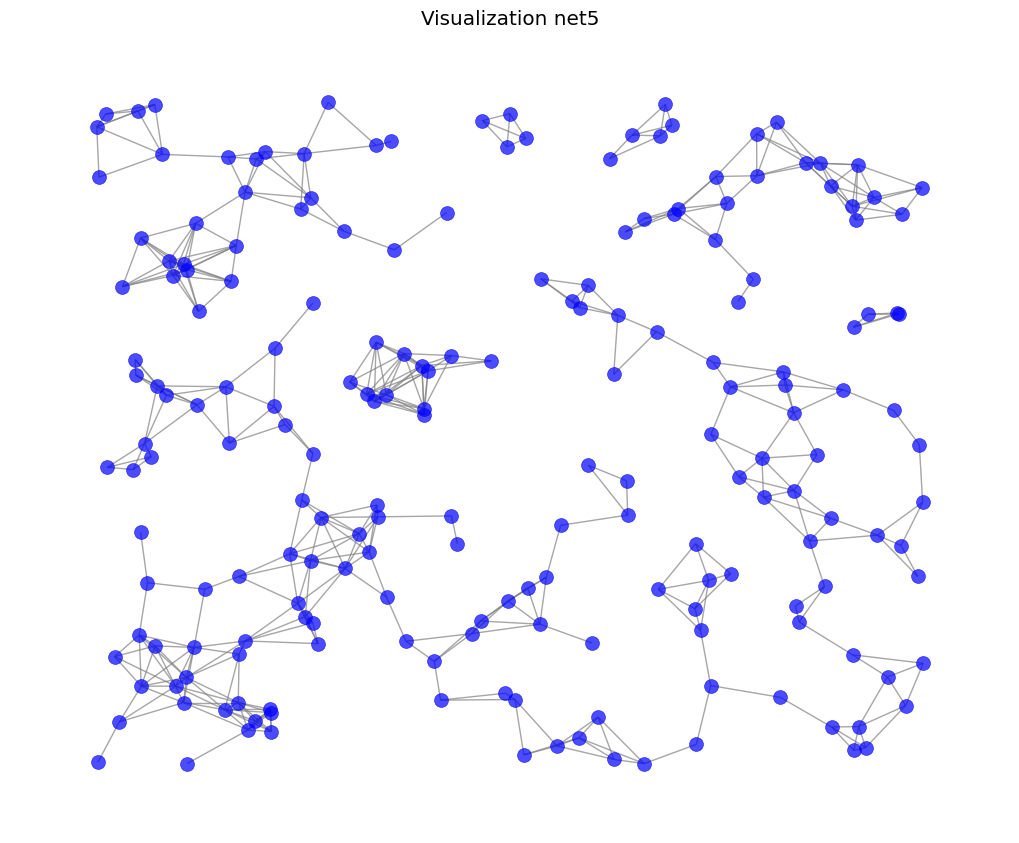

<Figure size 640x480 with 0 Axes>

In [47]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def visualize_net5():
    """Load and visualize the network net5 with the right positions."""
    G = load_network('net5')
    pos = np.loadtxt('data/positions_net5.txt', skiprows=1)
    pos_dict = {int(row[0]): (row[1], row[2]) for row in pos}
    
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos=pos_dict, node_size=100, node_color='blue', edge_color='gray', alpha=0.7)
    
    plt.title("Visualization net5")
    plt.show()
    plt.savefig('plots/net5_visualization.png')

visualize_net5()

### Proposed Algorithm
The code below recreates the network, emulating the model that created it

In [48]:
# TODO l'algoritmo per ricreare net5.net
#  o qualsiasi altro metodo per confermare che sia quello il modello
